In [2]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

In [3]:



print('Copying files...')
!cp -R ../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/* ./LungColon
print('All files copied successfully!')

Copying files...
All files copied successfully!


In [4]:
folders = glob('./LungColon' + '/*')

In [5]:
print('New Paths: ', folders)

IMAGE_FILES = glob('./LungColon' + '/*/*.jpeg')
print('Images Count: ', len(IMAGE_FILES))

New Paths:  ['./LungColon/lung_n', './LungColon/lung_aca', './LungColon/lung_scc']
Images Count:  15000


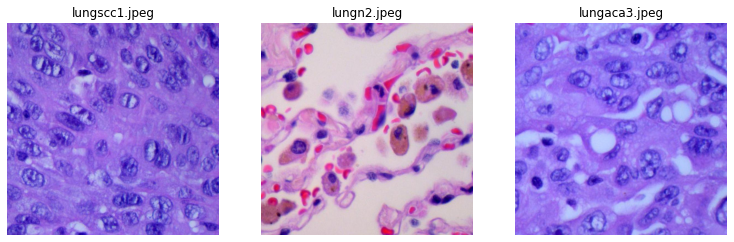

In [6]:
SAMPLES = ['./LungColon/lung_scc/lungscc1.jpeg', './LungColon/lung_n/lungn2.jpeg', 
           './LungColon/lung_aca/lungaca3.jpeg', ]

plt.figure(figsize=(22, 8)) 
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.title(t[3])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

In [7]:
data_dir = './LungColon'


data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128


X = Y = 224

train_ds = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

Found 12000 images belonging to 3 classes.


In [8]:
validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 3000 images belonging to 3 classes.


In [9]:
ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='imagenet',
    include_top=False)

ptm.trainable = False

K = len(folders)

x = GlobalAveragePooling2D()(ptm.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

y = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=y)

2022-09-21 05:53:54.584922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 05:53:54.685245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 05:53:54.686099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 05:53:54.687901: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

258088960/258076736 [==============================] - 1s 0us/step


In [10]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_ds,
    validation_data=validation,
    epochs=50,
    callbacks=[early_stopping])

2022-09-21 05:54:05.681477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-09-21 05:54:24.776455: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


94/94 [==============================] - 197s 2s/step - loss: 0.4475 - accuracy: 0.7983 - val_loss: 0.1747 - val_accuracy: 0.9370
Epoch 2/50
94/94 [==============================] - 167s 2s/step - loss: 0.2124 - accuracy: 0.9180 - val_loss: 0.1700 - val_accuracy: 0.9387
Epoch 3/50
94/94 [==============================] - 167s 2s/step - loss: 0.1669 - accuracy: 0.9365 - val_loss: 0.1471 - val_accuracy: 0.9403
Epoch 4/50
94/94 [==============================] - 167s 2s/step - loss: 0.1334 - accuracy: 0.9464 - val_loss: 0.0936 - val_accuracy: 0.9640
Epoch 5/50
94/94 [==============================] - 167s 2s/step - loss: 0.1193 - accuracy: 0.9517 - val_loss: 0.0811 - val_accuracy: 0.9680
Epoch 6/50
94/94 [==============================] - 167s 2s/step - loss: 0.1025 - accuracy: 0.9592 - val_loss: 0.0797 - val_accuracy: 0.9653
Epoch 7/50
94/94 [==============================] - 166s 2s/step - loss: 0.1017 - accuracy: 0.9607 - val_loss: 0.1281 - val_accuracy: 0.9443
Epoch 8/50
94/94 [======

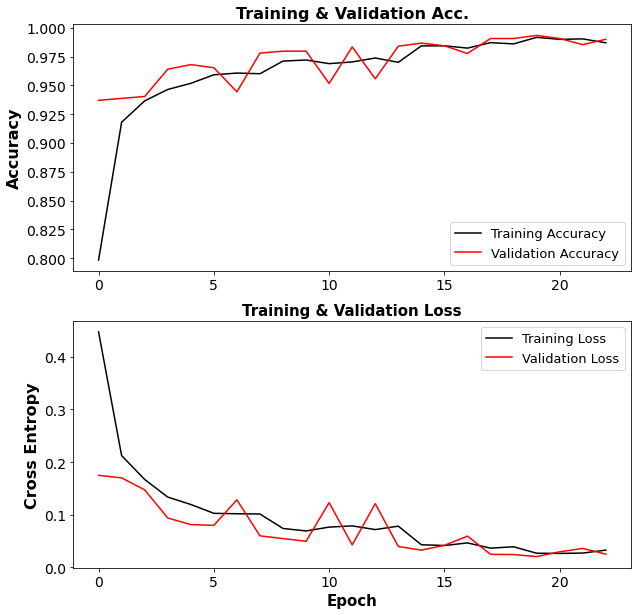

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='black')
plt.plot(val_acc, label='Validation Accuracy', color='red')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='black')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()


In [16]:
from sklearn.metrics import classification_report

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1000
           1       0.99      1.00      1.00      1000
           2       0.99      0.99      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

Normalized confusion matrix


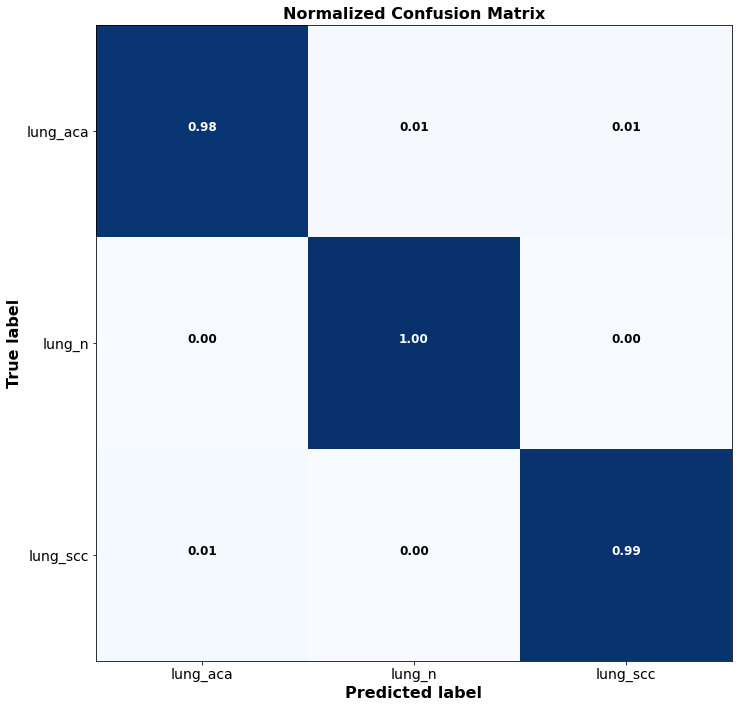

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()